In [2]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
import math
import itertools
import sys
import os
%matplotlib inline

## Intro to this Notebook

I have gone through two other versions of "titration effect" notebooks (see "Titration effect allows us to evaluate allosteric parameter" and "Titration effect revised"), both of which essentially acted as a set of notes for trying to determine how we can use fold-change titration curves to determine the allosteric parameter for LacI, $e^{-\beta \epsilon}$. In this notebook I hope to finalize my ideas on this subject in a way that is more legible to others. 

## How can we determine the allosteric parameter?

The allosteric parameter has proven elusive to us. This is partially because it is essentially impossible to fit from the IPTG titration curves we have been producing; a wide range of allosteric parameter values give equally good fits. Additionally, for "Hernan-style" titration curves in which we vary R by changing the LacI RBS, the allosteric parameter can be absorbed into the energy term, rendering it invisible. The LacI-operator binding energies we all know and love are, in fact, effective energies that include both the allosteric parameter and the actual LacI-operator binding energy. This is the one parameter in the MWC framework for LacI simple repression for which our models have been almost entirely unhelpful. However, I believe that titration experiments in which the number of operators is greater than 1 may enable us to determine the allosteric parameter.

In their Cell 2014 paper, Franz and Brewster measured fold-change for systems with various operator copy numbers using the equation 

\begin{equation}
\mathrm{fold-change} = \frac{\sum_{m=0}^{\mathrm{min}(N,R)} \frac{R!}{(N_{NS})^m(R-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}} (N-m)}{N \sum_{m=0}^{\mathrm{min}(N,R)} \frac{R!}{(N_{NS})^m(R-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}}},
\end{equation}

where $R$ is the number of repressors, $N$ is the number of operators, and $e^{-\beta \Delta \epsilon_\mathrm{DNA}}$ is the binding energy between LacI and the operator. This model assumes that all of the repressors are active and available for binding to operators. However, this may not be true; if the number of inactive repressors in the system is signficant, this model will not correctly describe the titration curve. In this notebook, I will explore two different models for including the probability that a repressor is active, $p_A$, in the expression for fold-change. Both models incorporate $e^{-\beta \epsilon}$ as a variable and would allow us to fit for this parameter. 

## Model 1: The fraction of active repressors is dependent only on the allosteric parameter

Our simplest model for LacI allostery says that the probability that a repressor is active, $p_A$, is determined by $e^{-\beta\epsilon}$ using the equation $p_A = \frac{1}{1 + e^{-\beta\epsilon}}$. This can be incorporated into the model for fold change by simply substituting $R_A = p_A R_\mathrm{tot}$ for $R$, giving us the equation 

\begin{equation}
\mathrm{fold-change} = \frac{\sum_{m=0}^{\mathrm{min}(N,R_A)} \frac{R_A!}{(N_{NS})^m(R_A-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}} (N-m)}{N \sum_{m=0}^{\mathrm{min}(N,R_A)} \frac{R_A!}{(N_{NS})^m(R_A-m)!} \binom{N}{m} e^{-\beta m \Delta \epsilon_\mathrm{DNA}}}.
\end{equation}

I wrote a function to plot this expression:

In [3]:
def model_1(eBE,N,Op):
    
    '''Calculates fold-change based on model 1 for pA. 
    eBE is the allosteric parameter;
    N is the number of operators;
    Op is the "Hernan" energy value for operator binding (in kBT); this is converted into the actual energy value.'''
    
    Rtot = np.logspace(0.0, 3.0, 100) #Array of repressor copy numbers
    pA = 1/(1 + eBE)     #probability that a given repressor is active
    Op = Op + np.log(pA)    #Convert Hernan energy values to actual energy values
    NNS = 4.6E6    #Number of nonspecific sites
    fc = []      #This will be my fold-change array
    
    for R in Rtot: #Here I use a loop to perform the summation and calculate fold-change
        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(pA*R)), N)+1):
            t += mp.factorial(mp.floor(pA * R))/((NNS**m)*mp.factorial(mp.floor(pA*R - m)))*mp.binomial(N,m)*np.exp(-m*Op)*(N-m)
            b += mp.factorial(mp.floor(pA * R))/((NNS**m)*mp.factorial(mp.floor(pA*R - m)))*mp.binomial(N,m)*np.exp(-m*Op)
        fc.append(float(t/(N*b)))
    return (Rtot, fc)

An interesting feature of this expression is that varying the value of $e^{-\beta \epsilon}$ causes a distinct left-shift in the titration curve. The curves experience an inflection point at $R = N * (1 + e^{-\beta \epsilon})$ (plotted as a vertical dotted line for each value of $e^{-\beta \epsilon}$), giving us a simple way to estimate the value of $e^{-\beta \epsilon}$. 

In [4]:
#Establish parameters to be used in the plot

N = 10 
Op = -17.0
eBE_array = [0.0, 0.5, 1.0, 2.0]
colors = ['firebrick', 'steelblue', 'mediumpurple', 'slategray']
labels = [r'$e^{-\beta \epsilon} = 0.0$', r'$e^{-\beta \epsilon} = 0.5$', r'$e^{-\beta \epsilon} = 1.0$', r'$e^{-\beta \epsilon} = 2.0$']

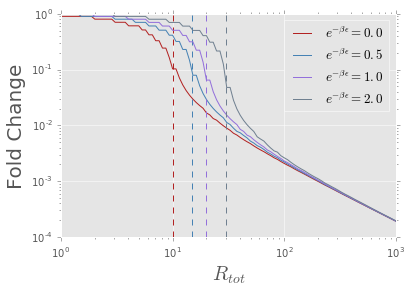

In [5]:
#Plot curves

plt.style.use('ggplot')

for i in range(0,len(eBE_array)):
    fold_change = model_1(eBE_array[i], N, Op)
    plt.axvline(x = N * (1 + eBE_array[i]), color = colors[i], ls='--')
    plt.loglog(fold_change[0], fold_change[1], color = colors[i], label = labels[i])
    
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel(r'$R_{tot}$', fontsize = 20)
plt.ylabel('Fold Change', fontsize = 20)
plt.legend(loc=0,fontsize = 13)

This is the model that Tal used to determine that $\beta \epsilon$ = 4.5 is the best fit for Franz and Rob's titration data. However, I believe that this model may not accurately affect the system, which I will discuss in the next section. 

## Model 2: Operator copy number affects the fraction of active repressors

Model 1 assumes that there are only two relevant states available to the repressor: active or inactive. However, there are actually four states available to the repressor: active and nonspecifically bound to DNA, inactive and nonspecifically bound to DNA, active and bound to an operator, and inactive and bound to an operator. If we make the simplifying assumption that inactive repressors do not bind to the operator, then the states and weights for a repressor can be expressed by the following image, where $O$ is the number of operators and $\Delta \epsilon_{Op,A}$ is the binding energy between the active repressor and the operator.  

<img src = "files/states.png", style="width: 50%; height: 50%">

If we take the operator-bound state into account, the probability that a repressor is active becomes

\begin{equation}
p_A = \frac{1 + \frac{O}{N_{NS}}e^{-\beta\epsilon_{Op,A}}}{1 + \frac{O}{N_{NS}}e^{-\beta \epsilon_{Op,A}} + e^{-\beta \epsilon}}.
\end{equation}

In this model, increasing the number of operators increases the likelihood that a given repressor will be active. 

Before we plot this model, we need to address a complication that is a consequence of the model. It is known that Hernan's binding energy values are inaccurate if $p_A$ is significantly smaller than 1. In fact, Hernan's binding energy values relate to the actual binding energy values by the equation $e^{-\beta \epsilon_\mathrm{Op,A,\ Hernan}} = p_A e^{-\beta \epsilon_\mathrm{Op,A,\ actual}}$. For Model 1, this conversion factor can be applied very easily because $p_A$ depends only on $e^{-\beta \epsilon}$. The conversion factor was included in the code for Model 1. However, in Model 2 $p_A$ depends on the value of $O$, $e^{-\beta \epsilon}$, and $e^{-\beta \epsilon_{Op,A}}$. The fact that the operator binding energy is part of the equation for $p_A$ makes it much more difficult to determine the actual binding energy from Hernan's binding energy. We need to solve for $e^{-\beta \epsilon_\mathrm{Op,A,\ actual}}$ in the equation

\begin{equation}
e^{-\beta \epsilon_\mathrm{Op,A,\ Hernan}} = \frac{1 + \frac{1}{N_{NS}}e^{-\beta\epsilon_\mathrm{Op,A,\ actual}}}{1 + \frac{1}{N_{NS}}e^{-\beta \epsilon_\mathrm{Op,A,\ actual}} + e^{-\beta \epsilon}} e^{-\beta \epsilon_\mathrm{Op,A,\ actual}}.
\end{equation}

Note that this equation is equivalent to $e^{-\beta \epsilon_\mathrm{Op,A,\ Hernan}} = p_A e^{-\beta \epsilon_\mathrm{Op,A,\ actual}}$ for $O = 1$. This reflects the fact that Hernan's energy values were calculated for strains containing a single operator. Solving for $e^{-\beta \epsilon_\mathrm{Op,A,\ actual}}$ yields the equation

\begin{equation}
e^{-\beta \epsilon_\mathrm{Op,A,\ actual}} =
\frac{\frac{e^{-\beta \epsilon_\mathrm{Op,A,\ Hernan}}}{N_{NS}} - 1 + 
\sqrt{\left(1 - \frac{e^{-\beta\epsilon_\mathrm{Op,A,\ Hernan}}}{N_{NS}} \right)^2 + 
4 e^{-\beta \epsilon_\mathrm{Op,A,\ Hernan}} \frac{\left(1 + e^{-\beta \epsilon} \right)}{N_{NS}}}}{\frac{2}{N_{NS}}}.
\end{equation}

Including this conversion factor along with the new definition of $p_A$ gives us the following results. 

In [106]:
def model_2(eBE,N,Op):
    
    '''Calculates fold-change based on model 2 for pA. 
    eBE is the allosteric parameter;
    N is the number of operators;
    Op is the "Hernan" energy value for operator binding (in kBT); this is converted into the actual energy value.'''
    
    Rtot = np.logspace(0.0, 3.0, 100) #Array of repressor copy numbers
    NNS = 4.6E6    #Number of nonspecific sites
    Op = -np.log((np.exp(-Op)/NNS -1 + np.sqrt((1 - np.exp(-Op)/NNS)**2 + 4 * np.exp(-Op)*(1 + eBE)/NNS))/(2/NNS)) #Convert Hernan energies
    pA = (1 + 1/NNS * np.exp(-Op))/(1 + 1/NNS * np.exp(-Op) + eBE)     #probability that a given repressor is active
    fc = []      #This will be my fold-change array
    
    for R in Rtot: #Here I use a loop to perform the summation and calculate fold-change
        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(pA*R)), N)+1):
            t += mp.factorial(mp.floor(pA * R))/((NNS**m)*mp.factorial(mp.floor(pA*R - m)))*mp.binomial(N,m)*np.exp(-m*Op)*(N-m)
            b += mp.factorial(mp.floor(pA * R))/((NNS**m)*mp.factorial(mp.floor(pA*R - m)))*mp.binomial(N,m)*np.exp(-m*Op)
        fc.append(float(t/(N*b)))
    return (Rtot, fc)

In [108]:
#Establish parameters to be used in the plot

N = 10 
Op = -17.0
eBE_array = [0.0, 0.5, 1.0, 2.0]
labels = [r'$e^{-\beta \epsilon} = 0.0$', r'$e^{-\beta \epsilon} = 0.5$', r'$e^{-\beta \epsilon} = 1.0$', r'$e^{-\beta \epsilon} = 2.0$']

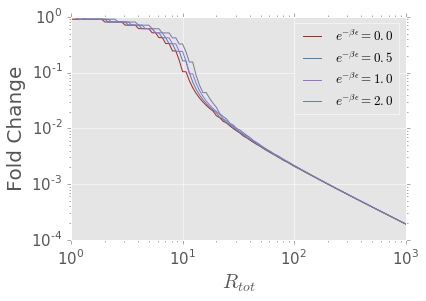

In [109]:
#Plot curves

plt.style.use('ggplot')

for i in range(0,len(eBE_array)):
    fold_change = model_2(eBE_array[i], N, Op)
    plt.loglog(fold_change[0], fold_change[1], color = colors[i], label = labels[i])
    
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel(r'$R_{tot}$', fontsize = 20)
plt.ylabel('Fold Change', fontsize = 20)
plt.legend(loc=0,fontsize = 13)

This plot shows that Model 2 is much more robust to changes in the allosteric parameter. Because $p_A$ increases with operator copy number, it dampens the effect of increasing the value of $e^{-\beta \epsilon}$. This makes it difficult to use this model to fit for the value of $e^{-\beta \epsilon}$. Using this model, Tal's fit to Franz and Brewster's data only showed that $e^{-\beta \epsilon} > 1$. 

However, there is another way to look at the data. Fixing the number of repressors at a constant value and varying the number of operators lends an enlightening perspective. Below, I plot the theory curves for Oid and R = 10. 

In [162]:
def model_2_var_N(eBE,R,Op):
    
    '''Calculates fold-change based on model 2 for pA with variable N. 
    eBE is the allosteric parameter;
    R is the number of repressors;
    Op is the "Hernan" energy value for operator binding (in kBT); this is converted into the actual energy value.'''
    
    N_vals = np.logspace(0.0, 2.0, 100) #Array of operator copy numbers
    NNS = 4.6E6    #Number of nonspecific sites
    Op = -np.log((np.exp(-Op)/NNS -1 + np.sqrt((1 - np.exp(-Op)/NNS)**2 + 4 * np.exp(-Op)*(1 + eBE)/NNS))/(2/NNS)) #Convert Hernan energies
    pA = (1 + 1/NNS * np.exp(-Op))/(1 + 1/NNS * np.exp(-Op) + eBE)     #probability that a given repressor is active
    fc = []      #This will be my fold-change array
    
    for N in N_vals: #Here I use a loop to perform the summation and calculate fold-change
        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(pA*R)), int(mp.floor(N)))+1):
            t += mp.fprod([mp.fdiv(mp.factorial(mp.floor(pA * R)), mp.fmul((NNS**m), mp.factorial(mp.floor(pA*R - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op), mp.floor(N)-mp.mpf(m)])
            b += mp.fprod([mp.fdiv(mp.factorial(mp.floor(pA * R)), mp.fmul((NNS**m), mp.factorial(mp.floor(pA*R - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op)])
        fc.append(float(t/(mp.floor(N)*b)))
    return (N_vals, fc)

In [176]:
#Establish parameters to be used in the plot

R = 10
Op = -17.0
eBE_array = [0.0, 0.5, 1.0, 2.0]
labels = [r'$e^{-\beta \epsilon} = 0.0$', r'$e^{-\beta \epsilon} = 0.5$', r'$e^{-\beta \epsilon} = 1.0$', r'$e^{-\beta \epsilon} = 2.0$']

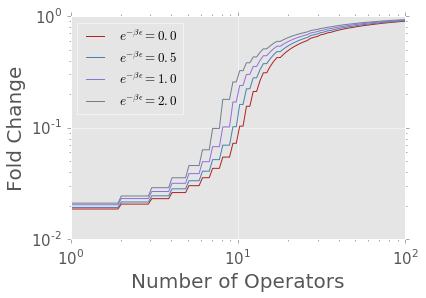

In [177]:
#Plot curves

plt.style.use('ggplot')

for i in range(0,len(eBE_array)):
    fold_change = model_2_var_N(eBE_array[i], R, Op)
    plt.loglog(fold_change[0], fold_change[1], color = colors[i], label = labels[i])
    
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.xlabel(r'Number of Operators', fontsize = 20)
plt.ylabel('Fold Change', fontsize = 20)
plt.legend(loc=0,fontsize = 13)

This plot shows decent separation for the different theory curves in a region around approximately $O = 10$. Taking data in this region could allow us to more effectively fit $e^{-\beta \epsilon}$. 